In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv('../data/processed_data_with_anomaly.csv')

In [5]:
features = ['Lag_1_Status', 'Count_Telat_7D', 'Count_Alpa_30D', 'Streak_Telat', 'Avg_Arrival_Time_7D', 'DayOfWeek']
le = LabelEncoder()

X = df[features]
# Encode 'Lag_1_Status' in the features
X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))

y = le.fit_transform(df['note'].astype(str))

C:\Users\hadid\AppData\Local\Temp\ipykernel_26600\870299856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))


In [6]:
# 80% train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris")

Data Latih: 101904 baris
Data Uji: 25476 baris


In [7]:
dt = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=25, min_samples_leaf=10, min_samples_split=2)
rf = RandomForestClassifier(random_state=42, max_depth=7, max_features=3, min_samples_split=5, n_estimators=50)
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, colsample_bytree=0.5, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=20, reg_lambda=1, seed=0)
nb = Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', GaussianNB(var_smoothing=1e-09))
        ])
svm = Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', SVC(random_state=42, C=1, gamma='scale', kernel='rbf'))
        ])

In [8]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Data latih setelah resampling: {X_train_res.shape[0]} baris")


Data latih setelah resampling: 170475 baris


Classification Report for DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.74      0.61      0.67     16819
           1       0.45      0.49      0.47      7735
           2       0.04      0.14      0.06       922

    accuracy                           0.55     25476
   macro avg       0.41      0.41      0.40     25476
weighted avg       0.63      0.55      0.58     25476



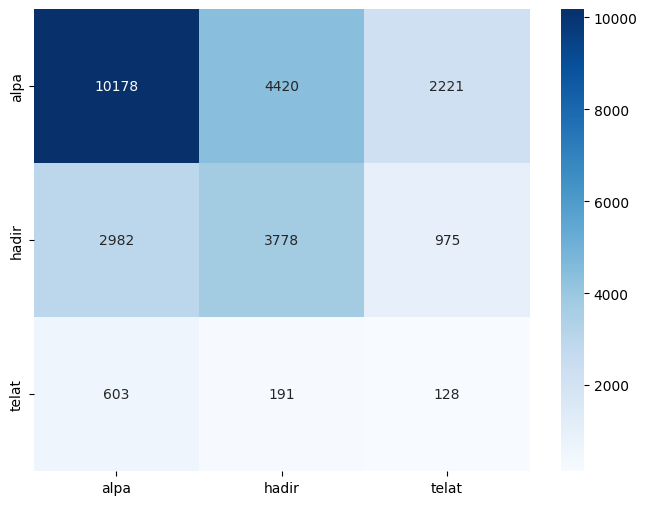

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.77      0.60      0.68     16819
           1       0.50      0.55      0.53      7735
           2       0.06      0.27      0.10       922

    accuracy                           0.57     25476
   macro avg       0.45      0.47      0.44     25476
weighted avg       0.66      0.57      0.61     25476



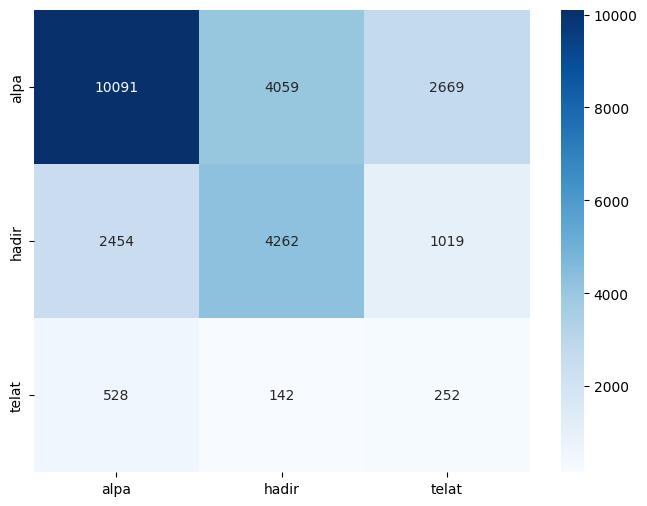

Classification Report for XGBClassifier
              precision    recall  f1-score   support

           0       0.76      0.50      0.61     16819
           1       0.50      0.57      0.53      7735
           2       0.06      0.37      0.11       922

    accuracy                           0.52     25476
   macro avg       0.44      0.48      0.41     25476
weighted avg       0.65      0.52      0.57     25476



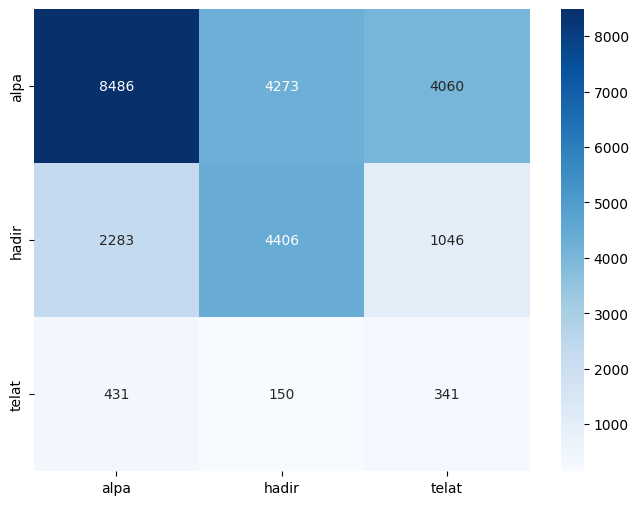

Classification Report for Pipeline
              precision    recall  f1-score   support

           0       0.77      0.41      0.54     16819
           1       0.38      0.75      0.51      7735
           2       0.10      0.13      0.11       922

    accuracy                           0.51     25476
   macro avg       0.42      0.43      0.38     25476
weighted avg       0.63      0.51      0.51     25476



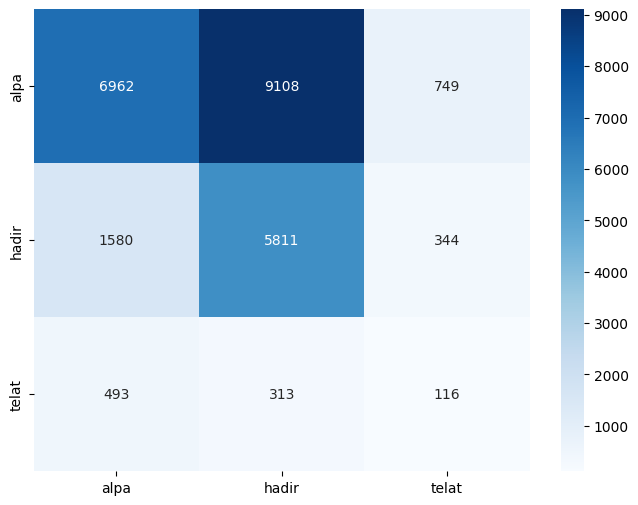

Classification Report for Pipeline
              precision    recall  f1-score   support

           0       0.79      0.48      0.60     16819
           1       0.47      0.58      0.52      7735
           2       0.08      0.53      0.15       922

    accuracy                           0.51     25476
   macro avg       0.45      0.53      0.42     25476
weighted avg       0.67      0.51      0.56     25476



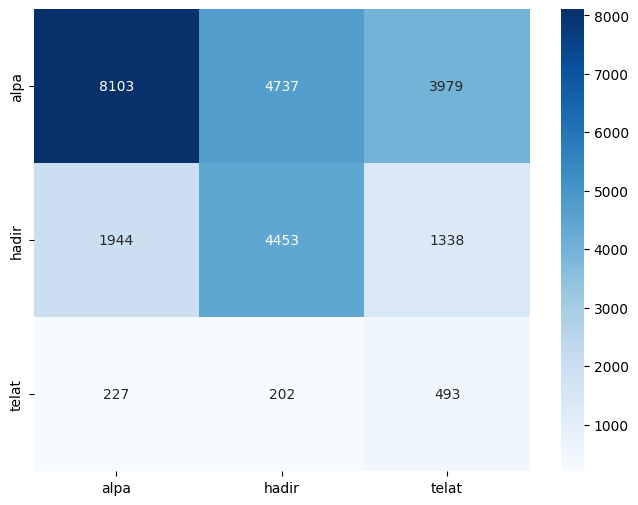

In [9]:
models = [dt, rf, xgb, nb, svm]
result = []

for model in models:
    y_pred = model.fit(X_train_res, y_train_res).predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    result.append({
        'Model': model.__class__.__name__,
        'Recall': recall,
        'F1-Score': f1
    })
    print("Classification Report for", model.__class__.__name__)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.show()
